# Import Libraries and Load Data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# List all data and label files
data_files = ['./DL-Project/data0.npy', './DL-Project/data1.npy', './DL-Project/data2.npy']
label_files = ['./DL-Project/lab0.npy', './DL-Project/lab1.npy', './DL-Project/lab2.npy']

# Load and concatenate all data and labels
raw_images = np.concatenate([np.load(f) for f in data_files], axis=0)
raw_labels = np.concatenate([np.load(f) for f in label_files], axis=0)

print(f"Images Shape: {raw_images.shape}")
print(f"Labels Shape: {raw_labels.shape}")

Using device: cuda
Images Shape: (30000, 40, 168)
Labels Shape: (30000,)


# Define Dataset Class

In [4]:
class DigitSumDataset(Dataset):
    def __init__(self, images, labels):
        # Normalize images to [0, 1] range
        self.images = images.astype('float32') / 255.0
        self.labels = labels.astype('float32')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Add channel dimension: (H, W) -> (1, H, W)
        image = torch.tensor(self.images[idx]).unsqueeze(0)
        label = torch.tensor(self.labels[idx])
        return image, label

# Prepare the DataLoaders
full_dataset = DigitSumDataset(raw_images, raw_labels)

# 80% Train, 20% Validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")

Training Samples: 24000
Validation Samples: 6000


# Model Definition

In [5]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        
        # Convolutional Layers (Feature Extraction)
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Adaptive Pool: Forces output to 4x4 regardless of input size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # Fully Connected Layers (Regression Head)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5), # Helps prevent overfitting
            nn.Linear(128, 1) # Output is 1 single number (the sum)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x.squeeze() # Remove extra dimensions

# Training

In [7]:
# Initialize Model, Loss, and Optimizer
model = BaselineCNN().to(device)
criterion = nn.MSELoss() # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 15
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    # --- TRAINING PHASE ---
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct_preds = 0
    total_preds = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            
            # Calculate Accuracy (Round to nearest integer)
            predicted = torch.round(outputs)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
            
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct_preds / total_preds
    
    print(f"Epoch [{epoch+1}/{EPOCHS}]  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}  Val Acc: {val_acc:.2f}%")

Epoch [1/15]  Train Loss: 43.4543  Val Loss: 33.1883  Val Acc: 6.25%
Epoch [2/15]  Train Loss: 30.2870  Val Loss: 14.9850  Val Acc: 10.65%
Epoch [3/15]  Train Loss: 19.9330  Val Loss: 10.6220  Val Acc: 11.95%
Epoch [4/15]  Train Loss: 16.9290  Val Loss: 9.7936  Val Acc: 13.20%
Epoch [5/15]  Train Loss: 15.4307  Val Loss: 8.9474  Val Acc: 14.52%
Epoch [6/15]  Train Loss: 13.9753  Val Loss: 7.0537  Val Acc: 15.57%
Epoch [7/15]  Train Loss: 12.9777  Val Loss: 8.5860  Val Acc: 14.82%
Epoch [8/15]  Train Loss: 12.3079  Val Loss: 6.2450  Val Acc: 16.30%
Epoch [9/15]  Train Loss: 11.7373  Val Loss: 5.7106  Val Acc: 16.93%
Epoch [10/15]  Train Loss: 11.0598  Val Loss: 5.7635  Val Acc: 16.67%
Epoch [11/15]  Train Loss: 10.5009  Val Loss: 5.5632  Val Acc: 17.18%
Epoch [12/15]  Train Loss: 10.0873  Val Loss: 5.0701  Val Acc: 18.50%
Epoch [13/15]  Train Loss: 9.6851  Val Loss: 5.0203  Val Acc: 17.50%
Epoch [14/15]  Train Loss: 9.4109  Val Loss: 4.7812  Val Acc: 18.88%
Epoch [15/15]  Train Loss: 8.

# Visualize

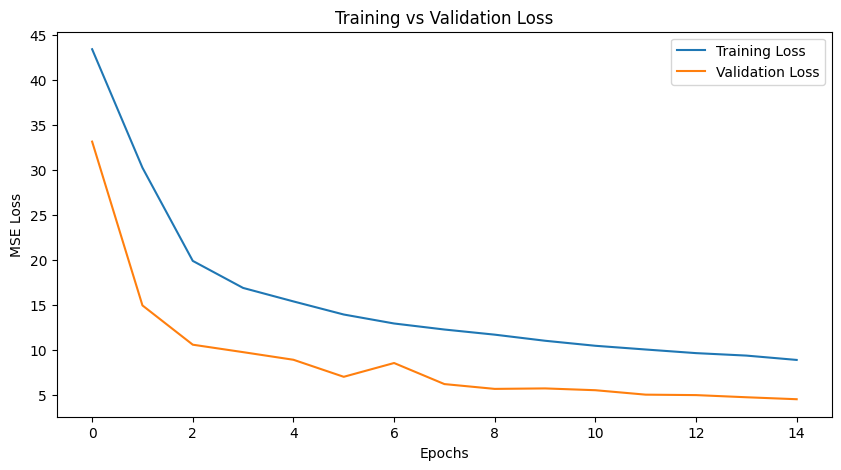

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Test on Random Samples

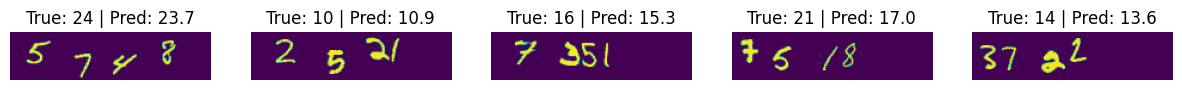

In [16]:
model.eval()
idx = np.random.randint(0, len(val_dataset), 5)

plt.figure(figsize=(15, 3))
for i, index in enumerate(idx):
    image, label = val_dataset[index]
    
    # Predict
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).item()
        
    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(image.squeeze().numpy(), cmap='viridis')
    plt.title(f"True: {label.item():.0f} | Pred: {pred:.1f}")
    plt.axis('off')

plt.show()